In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json

from os.path import join
from utils.paralell import agent_name
from utils.plotting import aligned_imshow_cbar

In [2]:
mpl.rcParams["font.size"] = 15
mpl.rcParams["figure.figsize"] = (12, 6)
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["axes.linewidth"] = 2
mpl.rcParams["xtick.major.width"] = 2
mpl.rcParams["ytick.major.width"] = 2
mpl.rcParams["xtick.major.size"] = 5
mpl.rcParams["ytick.major.size"] = 5

In [3]:
eta_dynamic = 1

In [4]:
path_output = join("data", "v1", f"simulation_{agent_name(eta_dynamic)}")

d_p = np.load(join(path_output, "d_p.npy"))
d_y = np.load(join(path_output, "d_y.npy"))
p_rich = np.load(join(path_output, "p_rich.npy"))
p_bank = np.load(join(path_output, "p_bank.npy"))
avg_len = np.load(join(path_output, "avg_len.npy"))
n_gamble_pairs = np.load(join(path_output, "n_gamble_pairs.npy"))

with open(join(path_output, "metadata.json"), "r") as f:
    meta = json.load(f)

In [5]:
agent_pair = [0, 1]

In [6]:
agent_pair_idx = meta["dimensions"]["0"].index(agent_pair)

n_gamma_thrs = meta["n_gamma_thrs"]
c_min = meta["c_min"]
c_max = meta["c_max"]
n_c = meta["n_c"]
agents = meta["agents"]
n_trials = meta["n_trials"]

d_p_opt = np.max(d_p[agent_pair_idx], axis=2)
d_y_opt = np.max(d_y[agent_pair_idx], axis=2)
d_p_argmax = np.argmax(d_p[agent_pair_idx], axis=2)
d_y_argmax = np.argmax(d_y[agent_pair_idx], axis=2)
opt_idx = np.unravel_index(np.argmax(d_p_opt), d_p_opt.shape)

c_range = np.linspace(meta["c_min"], meta["c_max"], meta["n_c"])

p_bank_opt = np.zeros((n_gamma_thrs, n_gamma_thrs))
p_rich_opt = np.zeros((n_gamma_thrs, n_gamma_thrs))
avg_len_opt = np.zeros((n_gamma_thrs, n_gamma_thrs))
a1, a2 = agents.index(agent_pair[0]), agents.index(agent_pair[1])
for i in range(n_gamma_thrs):
    for j in range(n_gamma_thrs):
        p_bank_opt[i, j] = 0.5 * (p_bank[a1, i, j, d_p_argmax[i, j]] + p_bank[a2, i, j, d_p_argmax[i, j]])
        p_rich_opt[i, j] = 0.5 * (p_rich[a1, i, j, d_p_argmax[i, j]] + p_rich[a2, i, j, d_p_argmax[i, j]])
        avg_len_opt[i, j] = 0.5 * (avg_len[a1, i, j, d_p_argmax[i, j]] + avg_len[a2, i, j, d_p_argmax[i, j]])
        
n_gp = np.mean(n_gamble_pairs, axis=2).astype(int)

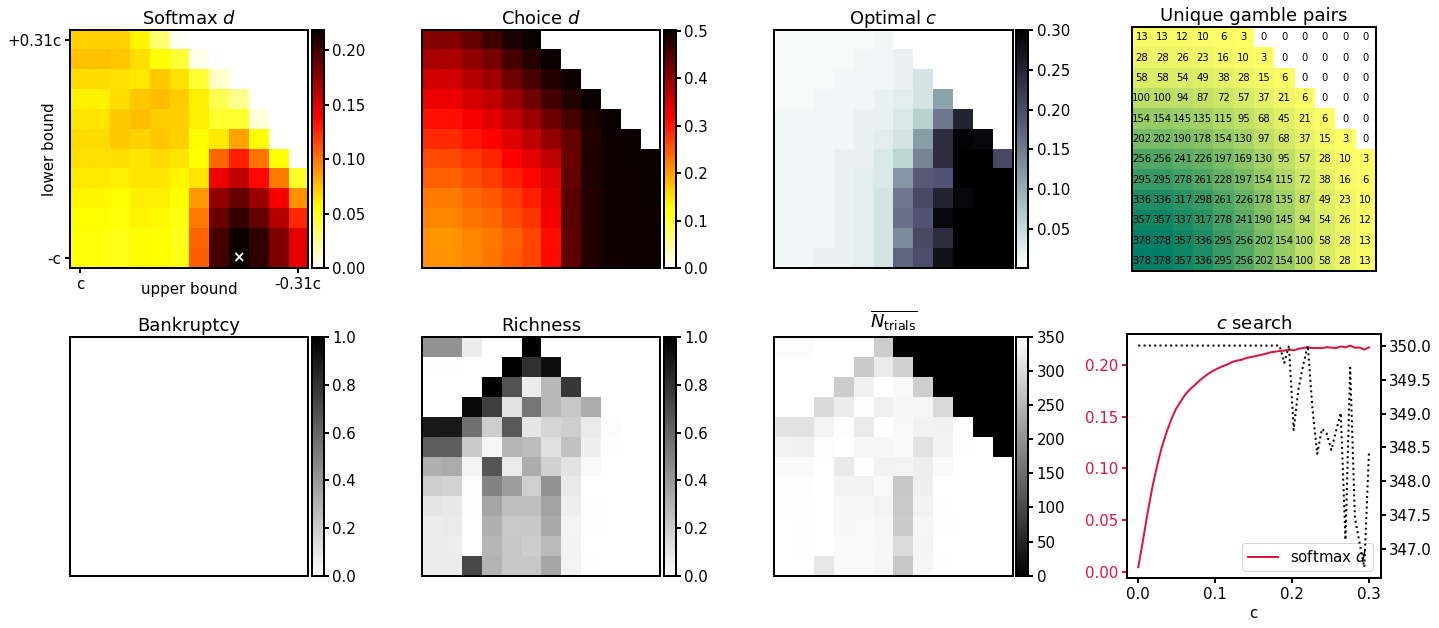

In [7]:
fig, axs = plt.subplots(figsize=(20, 9), ncols=4, nrows=2, facecolor="w")

# Disagreement 
im_dp = axs[0, 0].imshow(
    d_p_opt, 
    origin="lower", 
    cmap="hot_r",
)
axs[0, 0].set_ylabel("lower bound", labelpad=-50)
axs[0, 0].set_xlabel("upper bound", labelpad=-10)
axs[0, 0].set_title("Softmax $d$")
axs[0, 0].set_xticks([0, meta["n_gamma_thrs"] - 1])
axs[0, 0].set_yticks([0, meta["n_gamma_thrs"] - 1])
axs[0, 0].set_xticklabels(["c", f'{meta["dimensions"]["2"][0]:+.2f}c'])
axs[0, 0].set_yticklabels(["-c", f'{meta["dimensions"]["1"][-1]:+.2f}c'])
aligned_imshow_cbar(axs[0, 0], im_dp)
axs[0, 0].text(
    opt_idx[1], opt_idx[0], 
    s="×", c="white", va="center", ha="center",
    fontweight="bold"
)

im_dy = axs[0, 1].imshow(d_y_opt, origin="lower", cmap="hot_r")
axs[0, 1].set_title("Choice $d$")
aligned_imshow_cbar(axs[0, 1], im_dy)

# # Optimal growth rate
im_c = axs[0, 2].imshow(
    c_range[d_p_argmax], 
    origin="lower", 
    clim=[meta["c_min"], meta["c_max"]], 
    cmap="bone_r"
)
axs[0, 2].set_title("Optimal $c$")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
aligned_imshow_cbar(axs[0, 2], im_c)

# Bankruptcy
im_bank = axs[1, 0].imshow(p_bank_opt, origin="lower", clim=[0, 1], cmap="gray_r")
axs[1, 0].set_title("Bankruptcy")
aligned_imshow_cbar(axs[1, 0], im_bank)

# Richness
im_rich = axs[1, 1].imshow(p_rich_opt, origin="lower", clim=[0, 1], cmap="gray_r")
axs[1, 1].set_title("Richness")
aligned_imshow_cbar(axs[1, 1], im_rich)

# Average lenght
im_len = axs[1, 2].imshow(avg_len_opt, origin="lower", clim=[0, n_trials], cmap="gray")
axs[1, 2].set_title(r"$\overline{N_{\mathrm{trials}}}$", pad=10)
aligned_imshow_cbar(axs[1, 2], im_len)

# Number of unique gamble pairs 
cmap = mpl.cm.get_cmap("summer_r").copy()
cmap.set_under('white') 
axs[0, 3].imshow(n_gp, origin="lower", cmap=cmap, clim=[0.5, np.max(n_gp)])
axs[0, 3].set_title("Unique gamble pairs")
for i in range(n_gamma_thrs):
    for j in range(n_gamma_thrs):
        axs[0, 3].text(i, j, n_gp[i, j], ha="center", va="center", fontsize=10)

for i in range(2):
    for j in range(4):
        if (i, j) != (0, 0) and (i, j) != (1, 3):
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            
# Growth rate search
axs[1, 3].plot(
    c_range,
    d_p[agent_pair_idx][opt_idx],
    c="crimson",
    label="softmax $d$"
)
axs[1, 3].tick_params(axis='y', colors='crimson')
axs[1, 3].set_xlabel("c")
axs[1, 3].legend()
axs[1, 3].set_title("$c$ search")
axn = axs[1, 3].twinx()
axn.plot(
    c_range,
    avg_len[agent_pair_idx][opt_idx],
    c="black",
    ls=":"
)        


plt.tight_layout(w_pad=1.5, h_pad=1)